In [1]:
import sys, os
sys.path.append("/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/")
import caffe


In [4]:
caffe_root = "/afs/cs.stanford.edu/u/anenberg/scr/caffe/"

In [2]:


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Run ./scripts/download_model_binary.py models/bvlc_reference_caffenet to get the pretrained CaffeNet model, load the net, specify test phase and CPU mode, and configure input preprocessing.

In [5]:
caffe.set_phase_test()
caffe.set_mode_cpu()
net = caffe.Classifier(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                       caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
net.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy'))  # ImageNet mean
net.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
net.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Run a classification pass

In [6]:
scores = net.predict([caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')])

The layer features and their shapes (10 is the batch size, corresponding to the the ten subcrops used by Krizhevsky et al.)



In [7]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096, 1, 1)),
 ('fc7', (10, 4096, 1, 1)),
 ('fc8', (10, 1000, 1, 1)),
 ('prob', (10, 1000, 1, 1))]

In [8]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (1, 1, 4096, 9216)),
 ('fc7', (1, 1, 4096, 4096)),
 ('fc8', (1, 1, 1000, 4096))]

helper functions for visualization

In [9]:
# take an array of shape (n, height, width) or (n, height, width, channels)
#  and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

Input Image

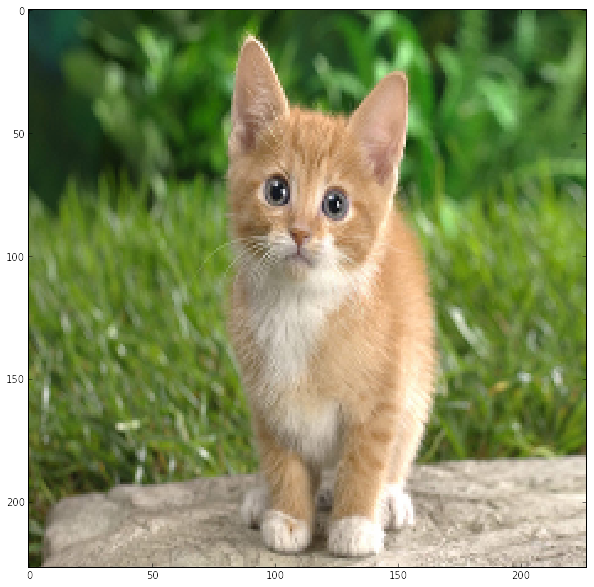

In [11]:
# index four is the center crop
plt.imshow(net.deprocess('data', net.blobs['data'].data[4]))


The first layer filters, conv1

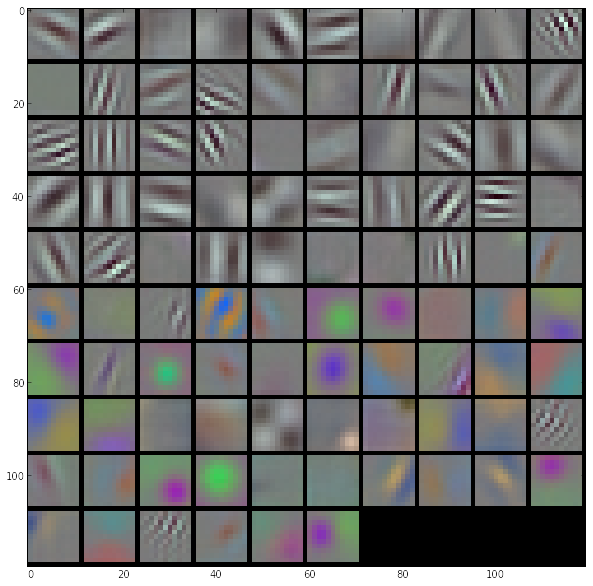

In [12]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, conv1 (rectified responses of the filters above, first 36 only)



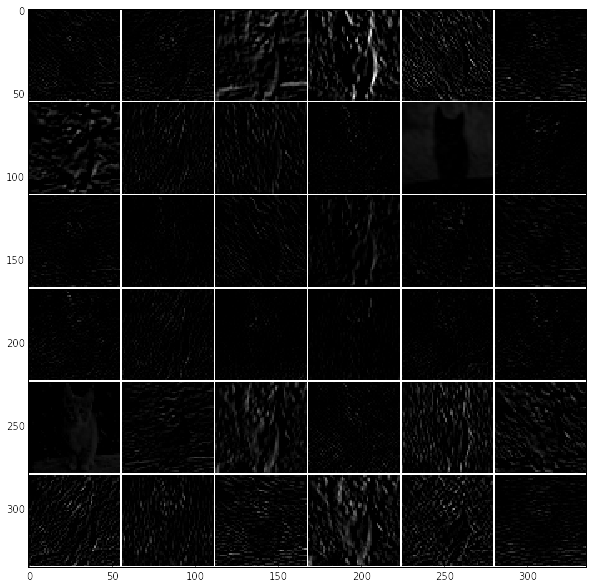

In [13]:
feat = net.blobs['conv1'].data[4, :36]
vis_square(feat, padval=1)

The second layer filters, conv2

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

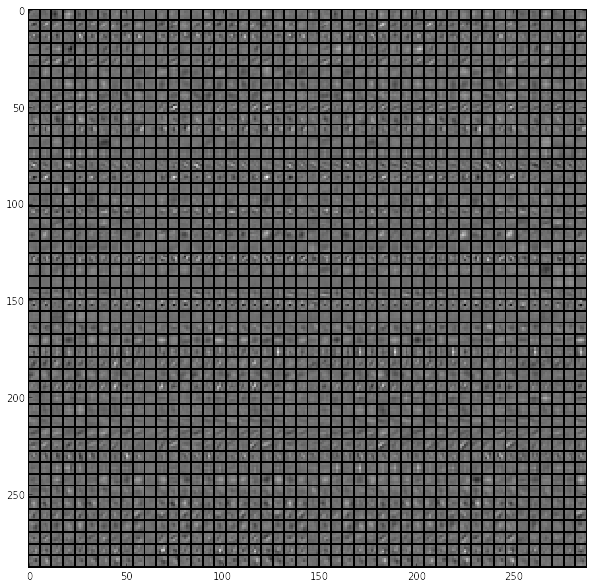

In [14]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

The second layer output, conv2 (rectified, only the first 36 of 256 channels)



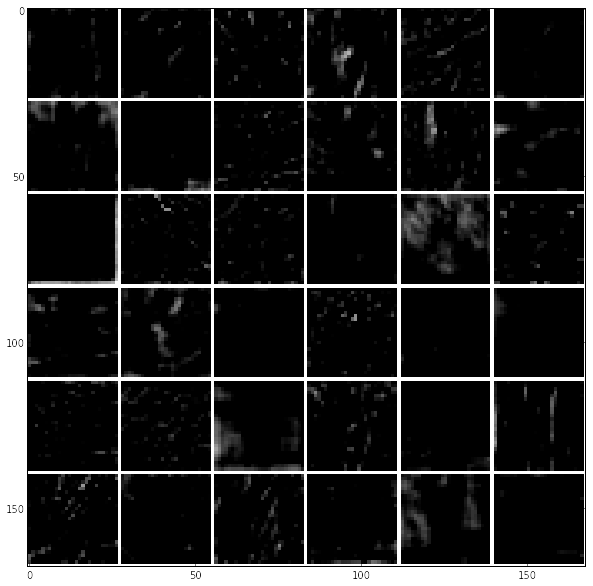

In [15]:
feat = net.blobs['conv2'].data[4, :36]
vis_square(feat, padval=1)

The third layer output, conv3 (rectified, all 384 channels)

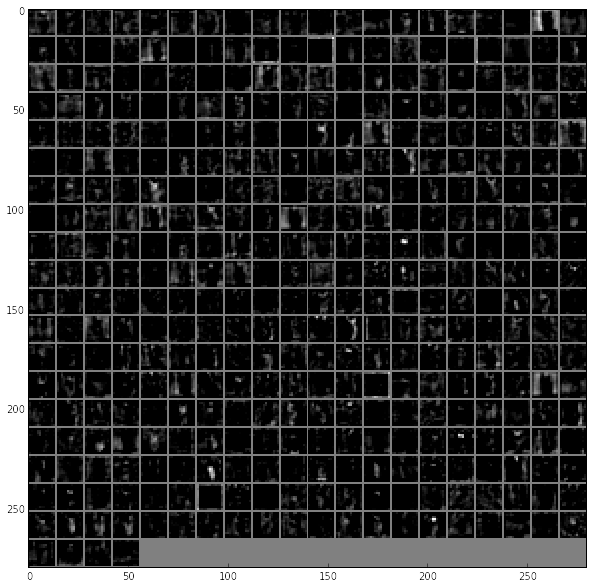

In [16]:
feat = net.blobs['conv3'].data[4]
vis_square(feat, padval=0.5)

The fourth layer output, conv4 (rectified, all 384 channels)



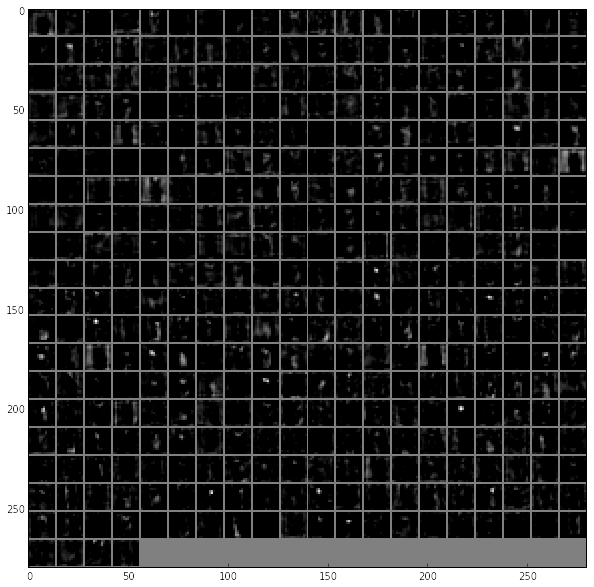

In [17]:
feat = net.blobs['conv4'].data[4]
vis_square(feat, padval=0.5)

The fifth layer output, conv5 (rectified, all 256 channels)


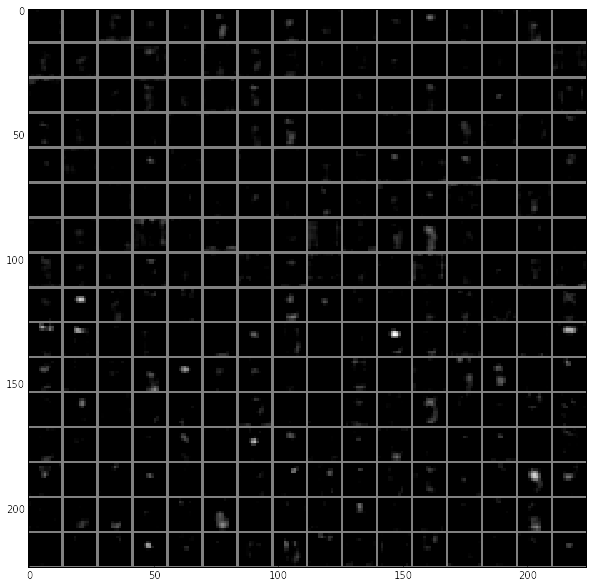

In [18]:
feat = net.blobs['conv5'].data[4]
vis_square(feat, padval=0.5)


The fifth layer after pooling, pool5

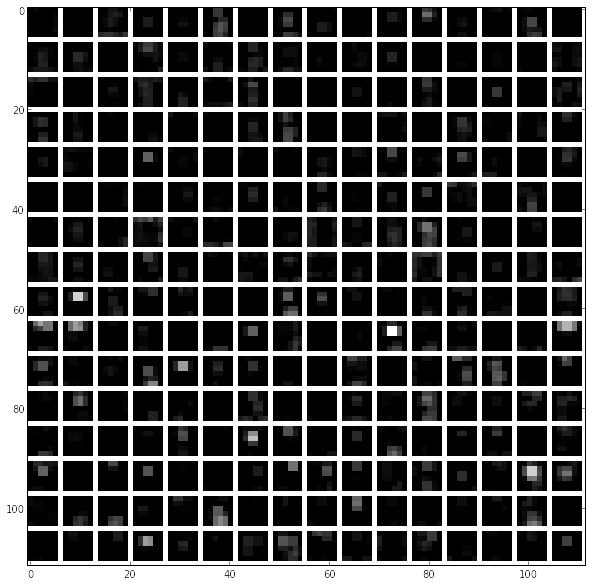

In [19]:
feat = net.blobs['pool5'].data[4]
vis_square(feat, padval=1)


The first fully connected layer, fc6 (rectified)

We show the output values and the histogram of the positive values

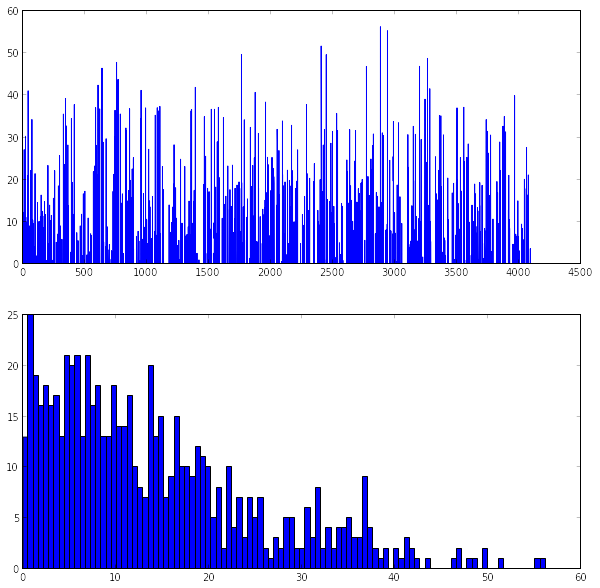

In [20]:
feat = net.blobs['fc6'].data[4]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The second fully connected layer, fc7 (rectified)

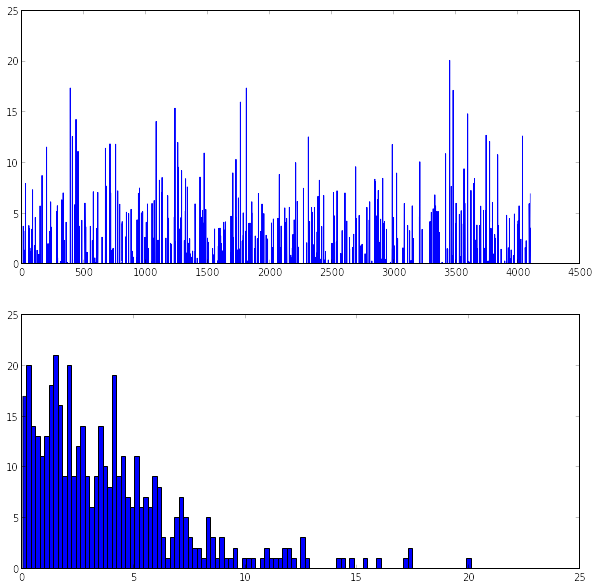

In [21]:
feat = net.blobs['fc7'].data[4]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The final probability output, prob

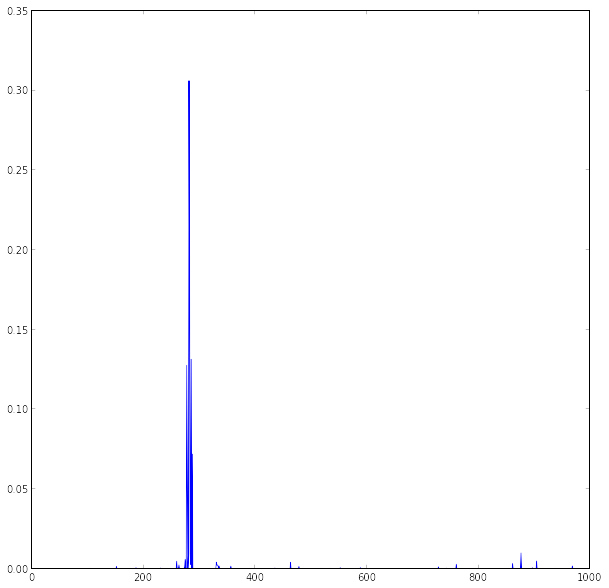

In [22]:
feat = net.blobs['prob'].data[4]
plt.plot(feat.flat)

Let's see the top 5 predicted labels.



In [24]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[4].flatten().argsort()[-1:-6:-1]
print labels[top_k]

Downloading...
--2015-02-11 22:05:21--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: `caffe_ilsvrc12.tar.gz'

100%[======================================>] 17,858,008  39.5M/s   in 0.4s    

2015-02-11 22:05:23 (39.5 MB/s) - `caffe_ilsvrc12.tar.gz' saved [17858008/17858008]

Unzipping...
Done.
['n02123045 tabby, tabby cat' 'n02123159 tiger cat'
 'n02124075 Egyptian cat' 'n02119022 red fox, Vulpes vulpes'
 'n02127052 lynx, catamount']
